In [ ]:
# Import for file handling
from pathlib import Path

import numpy as np

# Torch imports
import torch
from torch.nn.functional import relu, binary_cross_entropy_with_logits
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv

In [3]:
# Imports for Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#### MyDataset Class for handling downloading data

In [4]:
# MyDataset class for handling file loading

class MyDataset(Dataset):
    def __init__(self, path: Path):
        super().__init__()
        self.graphs = list(path.glob("*.pt"))
    
    def append(self, path: Path):
        self.graphs = self.graphs + list(path.glob("*.pt"))

    def __getitem__(self, idx):
        return torch.load(self.graphs[idx])
    
    def __len__(self) -> int:
        return len(self.graphs)

#### Obtaining the training data

In [7]:
# Load all batches into dataset a MyDataset class
dataset = MyDataset(Path("../dataset/batch_1_" + str(9)))
for i in range(9):
    dataset.append(Path("../dataset/batch_1_" + str(i)))

# Batch dataset using DataLoader
loader = DataLoader(dataset, batch_size=32)

#### Preliminary analysis of training data

In [8]:
# Preliminary analysis of dataset behavior

print("Number of graphs in set:", len(dataset))
print("Set of keys in each graph", dataset[0].keys)
print("Number of nodes in first graph:", dataset[0].num_nodes)
print("Number of edges in first graph:", dataset[0].num_edges)
print("Number of node features:", dataset[0].num_node_features)
print("Number of edge features:", dataset[0].num_edge_features)
print("Is this graph undirected? ", dataset[0].is_undirected())

Number of graphs in set: 9996
Set of keys in each graph ['edge_attr', 'x', 'y', 'edge_index']
Number of nodes in first graph: 298
Number of edges in first graph: 3230
Number of node features: 6
Number of edge features: 4
Is this graph undirected?  False


### Model Class

In [9]:
class GNN(torch.nn.Module):
    def __init__(self, sample, hidden_layers = [16], intra_hidden = 10):
        super().__init__()

        self.conv = []
        self.linear_weights = torch.randn(2 * sample.num_node_features + sample.num_edge_features)

        if len(hidden_layers) == 0:
            # Case when no hidden layers are passed

            nn = torch.nn.Sequential(
                torch.nn.Linear(sample.num_edge_features, intra_hidden),
                torch.nn.ReLU(),
                torch.nn.Linear(intra_hidden, sample.num_node_features)
            )
            self.conv.append(NNConv(sample.num_node_features, 1, nn))

        else:
            # Case when hidden layers are passed

            nn = self.simple_nn(sample.num_edge_features, intra_hidden, sample.num_node_features * hidden_layers[0])
            self.conv.append(NNConv(sample.num_node_features, hidden_layers[0], nn))

            for i in range(len(hidden_layers) - 1):
                nn = self.simple_nn(sample.num_edge_features, intra_hidden, hidden_layers[i] * hidden_layers[i + 1])
                self.conv.append(NNConv(hidden_layers[i], hidden_layers[i + 1], nn))    
            
            nn = self.simple_nn(sample.num_edge_features, intra_hidden, intra_hidden * hidden_layers[-1])
            self.conv.append(NNConv(hidden_layers[-1], intra_hidden, nn))

        # Last layer for making edge predictions from node + edge data
        self.edge_predictor = self.simple_nn(sample.num_edge_features + intra_hidden, intra_hidden, 1)

        self.conv_module = torch.nn.ModuleList(self.conv)
    
    def simple_nn(self, a_1, a_2, a_3):
        return torch.nn.Sequential(
            torch.nn.Linear(a_1, a_2),
            torch.nn.ReLU(),
            torch.nn.Linear(a_2, a_3)
        )

    def forward(self, data):

        x, edge_attr, edge_index = data.x, data.edge_attr, data.edge_index
        '''
        # Concatenate the edge attributes with the source node attributes
        '''
    
        for i in range(len(self.conv)):
            x = relu(self.conv[i](x, edge_index, edge_attr))

        src_node_attrs = x[edge_index[0]]
        conv_attributes = torch.cat((edge_attr, src_node_attrs), dim=1)
        edge_scores = self.edge_predictor(conv_attributes)

        return edge_scores.squeeze()

### Train Model

In [10]:
device = torch.device('cpu')
model = GNN(dataset[0]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=1e-4)

model.train()
loss_values = []
epoch_values = []
ref_values = []
ref_values = []
val = 0

for batch in loader:
    val += 1
    data = batch.to(device)
    optimizer.zero_grad()
    out = model(data)
    ones = 0.1 * torch.ones(len(out))
    zeros = torch.zeros(len(out))
    loss = binary_cross_entropy_with_logits(out, data.y)
    ref1 = binary_cross_entropy_with_logits(ones, data.y)
    ref2 = binary_cross_entropy_with_logits(zeros, data.y)
    loss_values.append(loss.item())
    epoch_values.append(val)
    ref_values.append(ref1)
    loss.backward()
    optimizer.step()

model.eval()
ref = np.mean(ref_values)
print("Final Loss: " + str(loss_values[-1]))

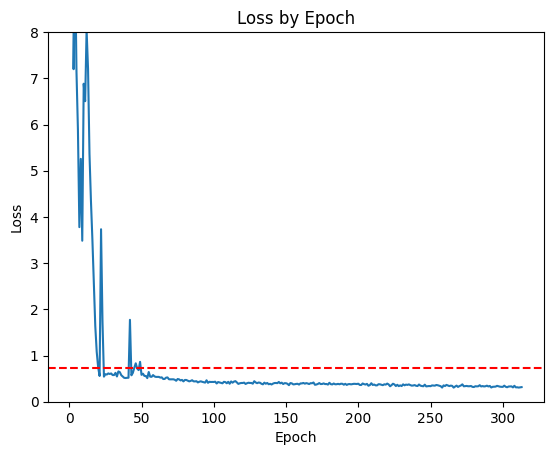

In [212]:
sns.lineplot(y=loss_values, x=epoch_values)

plt.title("Training Loss by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.axhline(y=ref, color='r', linestyle='--')

plt.ylim(0, 8)

plt.show()